In [1]:
import numpy as np
import jax.numpy as jnp
import jax
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import rho_plus as rp

is_dark = True
theme, cs = rp.mpl_setup(is_dark)
rp.plotly_setup(is_dark)

In [3]:
%cd /home/nicholas/programs/avid

/home/nicholas/programs/avid


In [4]:
from pymatgen.core import Structure
# matbench perov dataset

perovs = pd.read_json('data/castelli.json', orient='split')
perovs['struct'] = [Structure.from_dict(s) for s in perovs['structure']]
perovs.head()

,structure,e_form,struct
0,"{'@module': 'pymatgen.core.structure', '@class...",2.16,"[[0. 0. 0.] Rh, [1.97726555 1.97726555 1.97726..."
1,"{'@module': 'pymatgen.core.structure', '@class...",1.52,"[[2.54041798 0. 0. ] Hf, [1.020..."
2,"{'@module': 'pymatgen.core.structure', '@class...",1.48,"[[0.60790913 0. 0. ] Re, [2.186..."
3,"{'@module': 'pymatgen.core.structure', '@class...",1.24,"[[2.83091357 0. 0. ] W, [2.6573..."
4,"{'@module': 'pymatgen.core.structure', '@class...",0.62,"[[0.00518937 0. 0. ] Bi, [2.172..."


In [5]:
print({np.ptp(s.lattice.abc) for s in perovs['struct']})
print({s.lattice.is_orthogonal for s in perovs['struct']})
print({s.num_sites for s in perovs['struct']})

{0.0}
{True}
{5}


In [6]:
elements = set()
for struct in perovs['struct']:
    elements.update(set(struct.elements))

print(len(elements))
print(elements)

56
{Element Li, Element Be, Element B, Element N, Element O, Element F, Element Na, Element Mg, Element Al, Element Si, Element S, Element K, Element Ca, Element Sc, Element Ti, Element V, Element Cr, Element Mn, Element Fe, Element Co, Element Ni, Element Cu, Element Zn, Element Ga, Element Ge, Element As, Element Rb, Element Sr, Element Y, Element Zr, Element Nb, Element Mo, Element Ru, Element Rh, Element Pd, Element Ag, Element Cd, Element In, Element Sn, Element Sb, Element Te, Element Cs, Element Ba, Element La, Element Hf, Element Ta, Element W, Element Re, Element Os, Element Ir, Element Pt, Element Au, Element Hg, Element Tl, Element Pb, Element Bi}


In [7]:
sorted_elements = sorted(elements, key=lambda e: e.number)
elem_vals = [elem.symbol for elem in sorted_elements]
print(' '.join(elem_vals))

Li Be B N O F Na Mg Al Si S K Ca Sc Ti V Cr Mn Fe Co Ni Cu Zn Ga Ge As Rb Sr Y Zr Nb Mo Ru Rh Pd Ag Cd In Sn Sb Te Cs Ba La Hf Ta W Re Os Ir Pt Au Hg Tl Pb Bi


In [8]:
struct = perovs['struct'][40]
struct

Structure Summary
Lattice
    abc : 3.777430169179094 3.777430169179094 3.777430169179094
 angles : 90.0 90.0 90.0
 volume : 53.90007056062975
      A : 3.777430169179094 0.0 0.0
      B : 0.0 3.777430169179094 0.0
      C : 0.0 0.0 3.777430169179094
    pbc : True True True
PeriodicSite: Sb (0.002407, 0.0, 0.0) [0.0006373, 0.0, 0.0]
PeriodicSite: Li (1.908, 1.889, 1.889) [0.505, 0.5, 0.5]
PeriodicSite: F (1.889, 0.0, 1.889) [0.5, 0.0, 0.5]
PeriodicSite: O (1.888, 1.889, 0.0) [0.4999, 0.5, 0.0]
PeriodicSite: O (0.01636, 1.889, 1.889) [0.004332, 0.5, 0.5]

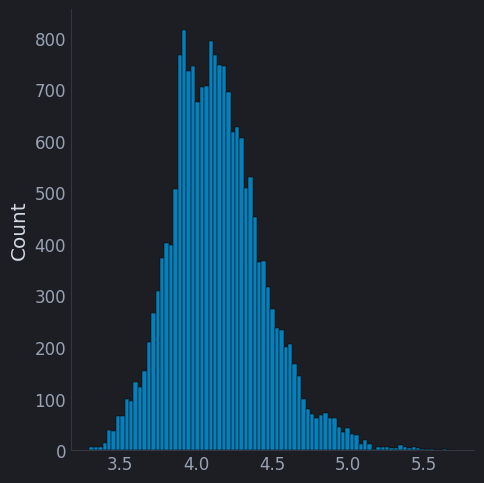

In [9]:
scales = np.array([struct.lattice.a for struct in perovs['struct']])
sns.displot(scales)

No idea what radial basis makes sense. For now, I use a Gaussian scaled so 1 is the peak, with standard deviation equal to half of the atomic radius.

In [10]:
from jaxtyping import Array, Float, PRNGKeyArray, Float32, Int
import functools as ft
from einops import rearrange, reduce
import equinox as eqx

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

dist = tfd.GeneralizedNormal(0.5, 2, 2)

N_GRID = 24
num_cells=4
grid_vals = jnp.linspace(0, 1, N_GRID + 1)[:-1]
xx, yy, zz = jnp.meshgrid(grid_vals, grid_vals, grid_vals)
xyz = rearrange(jnp.array([xx, yy, zz]), 'd n1 n2 n3 -> (n1 n2 n3) d')
xx, yy, zz = jnp.meshgrid(*[jnp.arange(-num_cells, num_cells + 1, dtype=jnp.float32)
                            for _ in range(3)])
shifts = rearrange(jnp.array([xx, yy, zz]), 'd n1 n2 n3 -> (n1 n2 n3) d')
dist.prob(xyz[None, :, :] + shifts[:, None, :]).prod(axis=2).sum(axis=0).mean()

Array(0.9956138, dtype=float32)

In [11]:

N_GRID = 24
power = 2
eff_scale = jnp.array(0.7)
num_cells = 4


distr = tfd.GeneralizedNormal(0, 1, power)
grid_vals = jnp.linspace(0, 1, N_GRID + 1)[:-1]
xx, yy, zz = jnp.meshgrid(grid_vals, grid_vals, grid_vals)
xyz = rearrange(jnp.array([xx, yy, zz]), 'd n1 n2 n3 -> (n1 n2 n3) d')

@ft.partial(jax.vmap, in_axes=(0, None, None, None))
@eqx.filter_jit()
def atom_density(xyz: Float[Array, '3'], atom_xyz: Float[Array, '3'], atom_rad: Float[Array, ''],num_cells: int = 4, distr: tfd.Distribution = distr) -> Float[Array, '']:
    """Atom density.
    xyz: Point at which to calculate density. Fractional coordinates.
    atom_xyz: Atomic center. Cartesian coordinates.
    num_cells: Controls how many cells are used to estimate the sum over all unit cells. Larger values provide slightly higher accuracy but take longer."""
    xx, yy, zz = jnp.meshgrid(*[jnp.arange(-num_cells, num_cells + 1, dtype=jnp.float32)
                                for _ in range(3)])
    shifts = rearrange(jnp.array([xx, yy, zz]), 'd n1 n2 n3 -> (n1 n2 n3) d')
    zscores = (xyz + shifts - atom_xyz) / atom_rad
    return jnp.sum(distr.prob(zscores).prod(axis=1) / distr.prob(0) ** 3)


def parse_grid(struct: Structure) -> (Float[Array, 'n3'], Int[Array, 'n3']):
    scale = struct.lattice.a
    total_dens = 0
    dens = jnp.zeros((N_GRID ** 3, len(elem_vals)))
    for site in struct.sites:
        specie = site.specie
        elem_i = elem_vals.index(specie.symbol)
        atom_dens = atom_density(xyz, site.frac_coords, specie.average_ionic_radius * eff_scale / scale, num_cells)
        dens = dens.at[:, elem_i].set(dens[:, elem_i] + atom_dens)

    total_dens = dens.sum(axis=1)
    species = dens.argmax(axis=1)
    return (total_dens, species)

total_dens, species = parse_grid(struct)

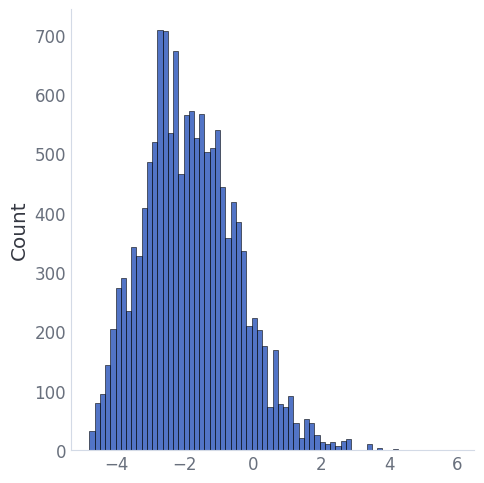

In [12]:
x = total_dens
sns.displot(jax.scipy.special.logit(x))

In [13]:
n_skip = 2
skip_mask = jnp.all(jnp.round(xyz * N_GRID) % n_skip == 0, axis=1)
bg_mask = total_dens > 0.1
mask = skip_mask & bg_mask
px.scatter_3d(
    x=xyz[mask, 0],
    y=xyz[mask, 1],
    z=xyz[mask, 2],
    color=total_dens[mask],
    # color=np.array(species[mask]).astype('str'),
    color_continuous_scale=rp.list_sequential,
    range_x=[0, 1], range_y=[0, 1], range_z=[0, 1],
    opacity=1,
)

In [14]:
px.scatter_3d(x=struct.frac_coords[:, 0], y=struct.frac_coords[:, 1], z=struct.frac_coords[:, 2], size=[site.specie.average_ionic_radius / struct.lattice.a for site in struct.sites], size_max=200,
              range_x=[0, 1], range_y=[0, 1], range_z=[0, 1], color=[spec.symbol for spec in struct.species])

In [15]:
# from tqdm import tqdm
# import gc

# data = {
#     'density': [],
#     'species': []
# }

# with jax.default_device(jax.devices('cpu')[0]):
#     for i, struct in tqdm(list(enumerate(perovs['struct']))[:52 * 4 * 3]):
#         dens, spec = parse_grid(struct)
#         data['density'].append(dens)
#         data['species'].append(spec)

#         if (i + 1) % 52 == 0:
#             data['density'] = jnp.array(data['density'], dtype=jnp.float32)
#             data['species'] = jnp.array(data['species'], dtype=jnp.int16)
#             eqx.tree_serialise_leaves(f'precomputed/densities/batch{i // 52}.eqx', data)
#             del data

#             gc.collect()
#             data = {
#                 'density': [],
#                 'species': []
#             }


In [18]:
data = eqx.tree_deserialise_leaves('precomputed/batch0.eqx',
                            {'density': jnp.zeros((52, 24 ** 3), dtype=jnp.float32),
                             'species': jnp.zeros((52, 24 ** 3), dtype=jnp.int16)})

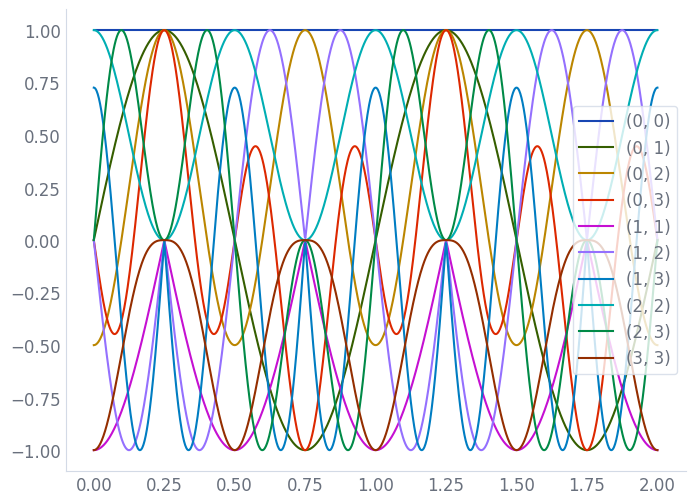

In [19]:
from scipy.special import *

xx = np.linspace(0, 2, 1000)


nm = 4
nn = 4
for m in range(nm):
    for n in range(nn):
        if m <= n:
            yy = lpmv(m, n, np.sin((xx % 1) * 2 * np.pi))
            plt.plot(xx, yy / max(abs(yy)), label=str((m, n)))

plt.legend()
# rp.line_labels()

In [26]:
from avid.config import MainConfig
from avid.dataset import dataloader

config = MainConfig()

data = next(dataloader(config, 'train'))

dens = data.density[3, ...]
dens_dense = dens[..., dens.max(axis=(0, 1, 2)) > 0]

(24, 24, 24, 56)

In [29]:
dens_dense = dens[..., dens.max(axis=(0, 1, 2)) > 0]
dens_dense.shape

(24, 24, 24, 4)

In [11]:
import pywt

dens = data['density'][3]

ModuleNotFoundError: No module named 'pywt'

In [21]:
print(' '.join(pywt.wavelist(kind='discrete')))

bior1.1 bior1.3 bior1.5 bior2.2 bior2.4 bior2.6 bior2.8 bior3.1 bior3.3 bior3.5 bior3.7 bior3.9 bior4.4 bior5.5 bior6.8 coif1 coif2 coif3 coif4 coif5 coif6 coif7 coif8 coif9 coif10 coif11 coif12 coif13 coif14 coif15 coif16 coif17 db1 db2 db3 db4 db5 db6 db7 db8 db9 db10 db11 db12 db13 db14 db15 db16 db17 db18 db19 db20 db21 db22 db23 db24 db25 db26 db27 db28 db29 db30 db31 db32 db33 db34 db35 db36 db37 db38 dmey haar rbio1.1 rbio1.3 rbio1.5 rbio2.2 rbio2.4 rbio2.6 rbio2.8 rbio3.1 rbio3.3 rbio3.5 rbio3.7 rbio3.9 rbio4.4 rbio5.5 rbio6.8 sym2 sym3 sym4 sym5 sym6 sym7 sym8 sym9 sym10 sym11 sym12 sym13 sym14 sym15 sym16 sym17 sym18 sym19 sym20


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


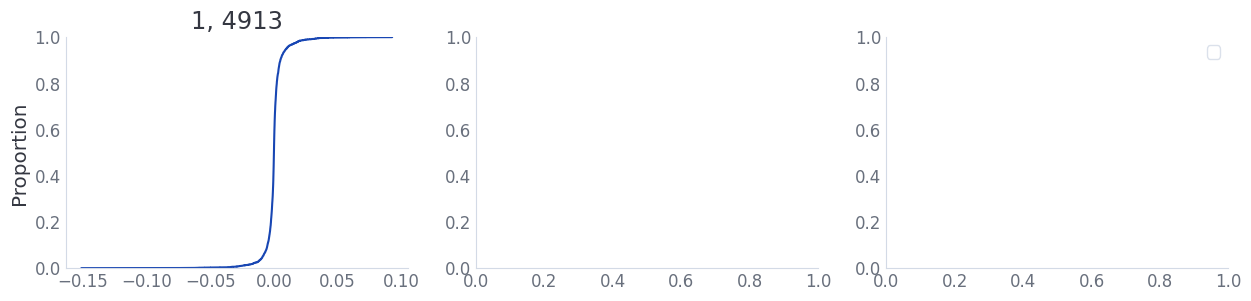

In [30]:
wavelet = 'rbio5.5'
method = 'periodic'
coeffs = pywt.wavedecn(dens, wavelet, method)
coef_arr, coef_slice = pywt.coeffs_to_array(coeffs)

from copy import deepcopy

n_plots = len(coeffs) - 1
n_cols = 3
n_rows = int(np.ceil(n_plots / n_cols))
fig, axs = plt.subplots(n_rows, n_cols, sharex=False, sharey=False,
                        figsize=(5 * n_cols, 3 * n_rows))


xyz_hats = []

for i, ax in zip(range(1, len(coeffs)), axs.flatten()):
    mask = [i]
    masked_coeffs = deepcopy(coeffs)
    n_coefs = len(coef_arr.flatten())
    for i in mask:
        masked_coeffs[i] = {k: np.zeros_like(v) for k, v in masked_coeffs[i].items()}
        n_coefs -= sum(len(arr.flatten()) for arr in masked_coeffs[i].values())
    xyz_hat = pywt.waverecn(masked_coeffs, wavelet, method)
    xyz_hats.append(xyz_hat)

    sns.ecdfplot((xyz_hat - dens).flatten(), ax=ax)
    ax.set_title(f'{i}, {n_coefs}')

plt.legend()

In [31]:
import functools as ft
from einops import rearrange, reduce

N_GRID = 24

grid_vals = jnp.linspace(0, 1, N_GRID + 1)[:-1]

xx, yy, zz = jnp.meshgrid(grid_vals, grid_vals, grid_vals)
xyz = rearrange(jnp.array([xx, yy, zz]), 'd n1 n2 n3 -> (n1 n2 n3) d')

cmap = rp.list_aquaria if is_dark else rp.list_cabana

def plot(dens, n_skip=2, thresh=0.1, cmap=cmap):
    bg_mask = abs(dens) > thresh
    skip_mask = jnp.all(jnp.round(xyz * N_GRID) % n_skip == 0, axis=1)
    mask = skip_mask & bg_mask
    return px.scatter_3d(
        x=xyz[mask, 0],
        y=xyz[mask, 1],
        z=xyz[mask, 2],
        color=dens[mask],
        # color=np.array(species[mask]).astype('str'),
        color_continuous_scale=cmap,
        range_x=[0, 1], range_y=[0, 1], range_z=[0, 1],
        opacity=1,
    )

plot(dens.reshape(-1))

In [33]:
plot(abs(dens - xyz_hats[-1]).reshape(-1), thresh=0.01)